# Zhenfeng Liang

# MTH9875 Homework 11

Assigned: November 12, 2015.
Due: November 26, 2015 by 6pm. (Yes I know it's Thanksgiving!)

Late homework **will not be accepted**.

<font color = "red">Homework is to be done by each student individually.  To receive full credit, you must email a completed copy of this iPython notebook to Tai-Ho Wang and Jim Gatheral by the due date and time.  All R-code must run correctly and solutions must be written up neatly in Markdown/LaTeX format.



### 0. (0 points)

Read Chapters 9 and 10 of The Volatility Surface

## Comparing stochastic and local volatility pricing of lookback options


$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
$$


In the following, a lookback call is defined to pay

$$
\left(S_{\text{max}}-K\right)^+
$$
where $S_{\text{max}}$ is the maximum and $K$ is the strike price.

### 1. (8 points)

Use (for example) the stochastic volatility and local volatility Monte Carlo codes (`HestonMCxmax` and `HestonLvMCxmax` respectively) from Lecture 11 to price a one year at-the-money lookback call
that is monitored once a day (assume 252 working days in a year).

Use the usual HN parameters  - namely:

$$
\begin{eqnarray*}
v&=& 0.04\\ \bar v &=& 0.04\\ \lambda&=&10\\ \eta&=&1\\\rho&=&-1.
\end{eqnarray*}
$$

Use 252 time steps and 20,000 paths.  Do not use Richardson extrapolation.

### Solution 1

In [1]:
evolveAlfonsiF <- function(v,x,dt,W1,W2,L){
  
  eldt2 <- exp(-lambda*dt/2);
  
  #Variance process 
  vbarp <- vbar - eta^2/(4*lambda);
  psi <- (1-eldt2)/lambda;
  v1 <- v*eldt2+lambda*vbarp*psi;
  v2 <- (v1 > 0) * v1; # Take v2 = 0 if v1<0, else v2=v1
  par <- sqrt(v2) + eta/2 * sqrt(dt)*W2;
  vf <- eldt2*par*par +lambda*vbarp*psi + v1 - v2;
  # Full truncation
  
  # Log-stock process (Andersen equation (33))
  vvf <- (v+vf > 0) * (v+vf);
  dw <- vvf/2*dt;
  x <- x  - dw/2 + rho2m1*sqrt(dw)*W1 +
    rho/eta*(lambda*dw + vf-v -lambda*vbar*dt) ;
  # Impose martingale constraint
  x <- x - log(mean(exp(x)));
  v <- vf;
  return(cbind(x,v));
}

### Heston Monte Carlo amended to return vectors x, v and max(x)

In [2]:
HestonMCxmax <- function(params){

  is.even <- function(j){as.logical((j+1) %% 2)}
  
  res <- function(S0, T, AK, N, m, evolve,exactVols=NULL)
  {
    
    lambda <<- params$lambda 
    rho <<- params$rho 
    eta <<- params$eta 
    vbar <<- params$vbar 
    v0 <<- params$v 
    
    n <- m*2  #n is number of timesteps = 2*m so we can use Romberg extrapolation
    sqrt2 <- sqrt(2) 
    rho2m1 <<- sqrt(1-rho*rho) 
    vbarp <<- vbar - eta^2/(4*lambda) 
    
    negCount <- 0 
    
    # We use a vertical array, one element per M.C. path
    x <- numeric(N);  v <- rep(1,N)*v0  
    xmax <- x 
    xm <- x  
    vm <- v
    xmaxm <- xmax 
    xmin <- numeric(N)  
    xminm <- numeric(N) 
    W1m <- numeric(N) 
    W2m <- numeric(N)  
    
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
      # Two sets of correlated normal random vars.
      
      W1 <- rnorm(N) 
      W2 <- rnorm(N) 
      W1 <- W1 - mean(W1)
      W1 <- W1/sd(W1) 
      W2 <- W2 - mean(W2)
      W2 <- W2/sd(W2) 
      # Now W1 and W2 are forced to have mean=0 and sd=1
      
      W2p <- W2 - cor(W1,W2)*W1  # Eliminate actual correlation
      W2p <- W2p - mean(W2p)  
      W2 <- W2p/sd(W2p)  
      # Now W1 and W2 have mean=0, sd=1 and correlation=0
      
      L <- rbinom(N, size=1, prob=1/2)  # Bernoulli rv for NV step
      
      # Add code for subgrid
      W1m <- W1m + W1/sqrt2
      W2m <- W2m + W2/sqrt2  # N(0,1) rv's for subgrid
      
      if (is.even(i)) {
        #print(c(i,mean(W1m),mean(W2m),sd(W1m),sd(W2m),cor(W1m,W2m))) 
        resm <- evolve(vm,xm,T/m,W1m,W2m,L) 
        xnewm <- resm[,1] 
        xmaxm <- (xnewm>xmaxm)*(xnewm-xmaxm)+xmaxm 
        xminm <- (xnewm<xminm)*(xnewm-xminm)+xminm 
        xm <- xnewm 
        vm <- resm[,2] 
        W1m <- numeric(N)  
        W2m <- numeric(N) 
      }
      
      res <- evolve(v,x,T/n,W1,W2,L) 
      xnew <- res[,1] 
      xmax <- (xnew>xmax)*(xnew-xmax)+xmax 
      xmin <- (xnew<xmin)*(xnew-xmin)+xmin 
      x <- xnew 
      v <- res[,2] 
      
    }
    
    return(data.frame(x,xm,v,vm,xmax,xmaxm,xmin,xminm)) 
    
  }
  return(res) 
}

### Local volatility Monte Carlo

In [3]:
# Monte Carlo with Richardson extrapolation
HestonLvMCxmax <- function(params){

  is.even <- function(j){as.logical((j+1) %% 2)}
  
  res <- function(S0, T, N, m)
  {
    
    lambda <- params$lambda;
    rho <- params$rho;
    eta <- params$eta;
    vbar <- params$vbar;
    v0 <- params$v;
    
    lambdap <- lambda+eta/2;
    vbarp <- vbar*lambda/lambdap;
    
    n <- m*2;
    dt <- T/n;
    dtm <- dt*2;
    
    sqrtdt <- sqrt(dt);
    sqrtdtm <- sqrt(dtm);
    sqrt2 <- sqrt(2);
    
    # We use a vertical array, one element per M.C. path
    x <- numeric(N); vloc <- rep(v0,N); 
    xm <- numeric(N); vlocm <- rep(v0,N); 
    xmax <- numeric(N); xmaxm <- numeric(N);
    xmin <- numeric(N); xminm <- numeric(N);
    W1m <- numeric(N);
    
    # Loop over timesteps
    for (i in 1:n)
    {
      W1 <- rnorm(N);
      W1 <- W1 - mean(W1); W1 <- W1/sd(W1);
      # Now W1 is forced to have mean=0 and sd=1  
      
      # Add code for subgrid
      W1m <- W1m + W1/sqrt2; # N(0,1) rv's for subgrid
      
      # Compute local variance from formula 4.1 of TVS
      ti <- i*dt;
      elti <- exp(-lambdap*ti);	
      vlocf <- (v0-vbarp)*elti+vbarp-eta*x*(1-elti)/(lambdap*ti);
      vlocf <- (vlocf>=0)*vlocf;
      
      # Approximate integrated variance
      w <- (vlocf +vloc)/2*dt;
      
      xnew <- x - w/2 + sqrt(w)*W1;
      xmax <- (xnew>xmax)*(xnew-xmax)+xmax;
      xmin <- (xnew<xmin)*(xnew-xmin)+xmin;
      x <- xnew;
      vloc <- vlocf;
      
      
      if (is.even(i)) {
        
        vlocfm <- (v0-vbarp)*elti+vbarp-eta*xm*(1-elti)/(lambdap*ti);
        vlocfm <- (vlocfm>=0)*vlocfm;
        
        wm <- (vlocfm+vlocm)/2*dtm;
        xnewm <- xm - wm/2 + sqrt(wm)*W1m;
        xmaxm <- (xnewm>xmaxm)*(xnewm-xmaxm)+xmaxm;
        xminm <- (xnewm<xminm)*(xnewm-xminm)+xminm;
        xm <- xnewm;
        vlocm <- vlocf;
        W1m <- numeric(N);
      } 
      
      
    }
    
    return(data.frame(x,xm,vloc,vlocm,xmax,xmaxm,xmin, xminm));
    
  }
  return(res);
}

In [4]:
priceLookback <- function(data, K)
{
    Smax <- exp(data$xmax)
   
    # Payoff for lookback  
    V <- (Smax>K) * (Smax - K);

    AV <- mean(V);
    
    return(AV);
}

In [5]:
# Heston-Nandi parameters
paramsCh4 <- list(lambda = 10,rho = -1,eta = 1,vbar = 0.04,v = 0.04)

N <- 20000

m <- 252 / 2

S0 <- 1

T <- 1

In [6]:
sampleLV <- HestonLvMCxmax(paramsCh4)(S0=S0, T=T, N=N, m=m);
sampleSV <- HestonMCxmax(paramsCh4)(S0=S0, T=T, N=N, m=m,evolve=evolveAlfonsiF);

In [7]:
lookBackSV <- priceLookback(sampleSV, S0)
lookBackLV <- priceLookback(sampleLV, S0)

paste('The price of the one year ATM lookback option under stochastic volatility model is', lookBackSV)
paste('The price of the one year ATM lookback option under local volatility model is', lookBackLV)

[1] "The price of the one year ATM lookback option under stochastic volatility model is 0.126354234438661"

[1] "The price of the one year ATM lookback option under local volatility model is 0.134252833920337"

### 2. (4 points) 

Plot local volatility and stochastic volatility prices of lookback options for a range of strikes from $1.0$ to $1.4$, reproducing Figure 8 of Lecture 11.

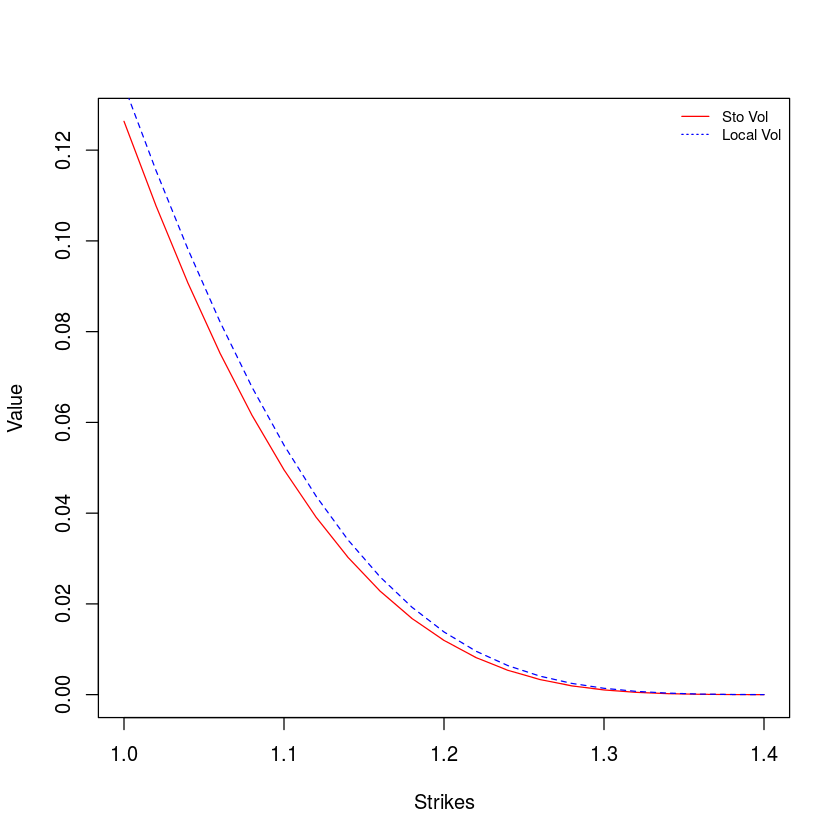

In [8]:
strikes <- seq(1,1.4,0.02)

lbSV <- sapply(strikes,function(K){priceLookback(sampleSV,K)})
lbLV <-sapply(strikes,function(K){priceLookback(sampleLV,K)})

plot(strikes, lbSV, col="red",type="l",ylab="Value",xlab="Strikes")
points(strikes, lbLV, col="blue",type="l", lty=2)

# add legend to the plot
legend('topright', c("Sto Vol","Local Vol"), lty=c("solid", "dotted"),
       col=c("red", "blue"), bty='n', cex=.75)

### 3. (6 points) 

What is the intuition behind the difference in price under stochastic volatility and local volatility assumptions respectively?  Appeal to the dynamics of the implied volatility skew in
your answer. 

We can look at this from the hedging argument. How do we hedge a lookback call option? If the spot never goes above the strike price, we don't need to do anything. Once the spot hit the strike, we sell a call strike at $K$ and by a call strike at $K + \Delta K$. We will make some money from each rebablance due to the negative skew. One of the difference between stochastic vol and local vol models is stochastic vol have a steeper skew than the local vol, which means we could make more money from each rebalance under stochastic vol than the local vol model. So, from basic no arbitrage argument, the value calculated from the stochastic vol model must be less than the value from the local vol model.'

## The effect of discreteness

### 4. (6 points) 

Repeat Problem 1 with weekly monitoring (assume 52 weeks).  Estimate the difference in price using the Broadie, Glasserman and Kou adjustment.  Compare with your Monte Carlo results and comment.

In [9]:
# Weekly monitors
mW <- 52 / 2

# Run the simulation with weekly monitoring
sampleLV_W <- HestonLvMCxmax(paramsCh4)(S0=S0, T=T, N=N, m=mW);
sampleSV_W <- HestonMCxmax(paramsCh4)(S0=S0, T=T, N=N, m=mW,evolve=evolveAlfonsiF);

In [10]:
lookBackSV_W <- priceLookback(sampleSV_W, S0)
lookBackLV_W <- priceLookback(sampleLV_W, S0)

paste('The price of the one year ATM lookback option under stochastic volatility model is', lookBackSV_W)
paste('The price of the one year ATM lookback option under local volatility model is', lookBackLV_W)

[1] "The price of the one year ATM lookback option under stochastic volatility model is 0.122220361308426"

[1] "The price of the one year ATM lookback option under local volatility model is 0.128897856944569"

In [11]:
# Implement the lookback option adjustment function
lookBackDiff <- function(sample, sample_W, lookBackPrice){
    # function to return the price difference between dialy monitoring and weekly monitoring
    
    sm <- mean(exp(sample$xmax))

    sm_W <- mean(exp(sample_W$xmax))

    eb <- sm_W / sm

    diff <- lookBackPrice * (1 - eb) + (1 - eb)

    return(diff)
}

### Sto vol difference

In [12]:
paste('The estimated price difference using Broadie, Glasserman and Kou adjustment is', 
      lookBackDiff(sampleSV, sampleSV_W, lookBackSV))

paste('The price difference from Monte Carlo results is', lookBackSV - lookBackSV_W)

[1] "The estimated price difference using Broadie, Glasserman and Kou adjustment is 0.00413387313023521"

[1] "The price difference from Monte Carlo results is 0.00413387313023511"

### Local vol difference

In [13]:
paste('The estimated price difference using Broadie, Glasserman and Kou adjustment is', 
      lookBackDiff(sampleLV, sampleLV_W, lookBackLV))

paste('The price difference from Monte Carlo results is', lookBackLV - lookBackLV_W)

[1] "The estimated price difference using Broadie, Glasserman and Kou adjustment is 0.00535497697576812"

[1] "The price difference from Monte Carlo results is 0.00535497697576806"

### Comments

From the result above, we can see under stochastic vol and local vol, the Broadie, Glasserman and Kou adjustment to estimate the discreteness difference is very accurate.